### Is Amazon killing Walmart?


*Brian Dew, @bd_econ, August 31, 2018*

Last year, I coauthored with Dean Baker a [blog post](http://cepr.net/blogs/cepr-blog/is-amazon-s-stock-price-justified-what-it-means-if-it-is) on **Amazon**'s absurdly high price-to-earnings (PE) ratio (~184 at the time the piece was written). The bottom line was that for Amazon's valuation to be in line with historical norms, either its stock price had to go down or its earnings had to go up. Since most of Amazon's early 2017 earnings were coming from its web services (AWS), investors seemed to be betting that the stock price was justified by future profits from the retail and subscription businesses. My sense is that they were specifically betting that Amazon's subscription model for selling retail goods was indeed profitable, but that the company had not turned on the profit part yet. That is, the company was generating cash, but instead of returing it to investors, it was spending the cash to keep growing. A related argument was that Amazon was growing into a company that could turn on its stream of profit by raising prices. Once enough people were subscribed to the convenient service, which Amazon could continue to scale and improve, the once-price-conscious shoppers would be willing to pay more for goods. 

As part of the [EPBC](https://briandew.wordpress.com/2018/08/31/economist-as-a-plumber-with-a-body-camera-epbc/) series, I've looked again at how Amazon is doing. It turns out that they generated quite large profits during each of the last three quarters. In the most recent quarter, which ended on June 30, 2018, Amazon generated 2.5 billion dollars in net income, by far its all-time largest. The North American retail portion of the business has become Amazon's largest source of profit, and the AWS stream now explains only about half. What makes the record quarter for Amazon more interesting, is that **Walmart**, by-far the largest private employer in the US (Amazon is second), generated a sizable net loss in Q2. Some of Walmart's quarterly net loss came from a one-off transaction in Brazil, but the timing allows a much different picture of the two companies' profitability to emerge. Amazon is now more profitable than Walmart.

![Graph - Net Income/Loss Amazon and Walmart](AmazonWalmartNetIncomeLoss.png)

Much more in-depth analysis is required to reach a conclusion about how these two companies will fare in the future, but it's worth noting that Amazon still has an absurd valuation. Amazon's earnings have taken off over the last year, but so has its stock price, which more than doubled. Amazon's market cap is [nearing a trillion dollars](https://www.bloomberg.com/news/articles/2018-08-29/amazon-and-alphabet-have-a-new-number-one-fan-on-wall-street), and its PE ratio is still above 180 (the historic norm for a publically-traded company is around 20). Lower corporate taxes and a strong economic forecast offer some justification for higher stock prices, but the simple point is that **Amazon, now massively profitable, is still being treated as a high-growth investment.** While a lot has changed over the past year, the bottom line really hasn't. Either Amazon's stock price goes down or its profits go up. 

----


#### EPBC

Part of the EPBC series (in addition to revisiting older work) is showing my work. In this case, the data work was admittedly very light. I pulled the 2011-onward net income series for both companies from the [US Stocks Fundamentals API](http://www.usfundamentals.com/) and then looked through their most recent quarterly reports, retrieved from the companies' investor relations websites ([Amazon](http://phx.corporate-ir.net/phoenix.zhtml?c=97664&p=irol-sec), 
[Walmart](http://stock.walmart.com/investors/financial-information/sec-filings/default.aspx)). I then looked up Amazon's stock price on Google finance (retrieved before market open on August 31, 2018). 

Here's the python script that pulls almost all of the data and generates the graph above:


#### Requirements:

Python (3.6 used) with the requests package and pandas<br>API `key` from usfundamentals.com (free).

In [1]:
# Import python libraries
import requests
import pandas as pd
from io import StringIO
import matplotlib.pyplot as plt

# File containing API key
from config import usfun_key as key

#### Get company IDs

The company ID is the same one used in SEC filings (the source of the data). Here is an example of how to put in a loose string related to a company name, like 'Amazon' and retrieve, from the US stock fundamentals API, the associated company ID. 

In [2]:
# For selected companies, get company ID
sel_comp = ['Amazon', 'Walmart']

base = 'https://api.usfundamentals.com/v1/' # API url
param = f'companies/xbrl?&format=json&token={key}'

# Request data from US fundamentals API
r = requests.get(f'{base}{param}').json()

# ID numbers for selected companies
c = {int(i['company_id']): i['name_latest'] for i in r 
     if any(sc in i['name_latest'] for sc in sel_comp)}

print(c)

{1018724: 'Amazon COM Inc', 104169: 'Walmart Inc.'}


#### Retrieve net income for companies

I wasn't able to get the API to return the net income data in json format, instead, StringIO makes the API result readable for pandas. 

In [3]:
# New parameters to retrieve data
freq = 'frequency=q'
cik = f'companies={",".join([str(k) for k in c.keys()])}'
ind = 'indicators=NetIncomeLoss'
param = f'/indicators/xbrl?{cik}&{ind}&{freq}&token={key}'
r = requests.get(f'{base}{param}').text

# Convert API result to pandas dataframe
df = pd.read_csv(StringIO(r)).T
df.columns = list(df.iloc[0].map(c))
df = df.iloc[2:]

#### Adding latest datapoint manually

The Q2 results from Walmart have been released on August 16, but not yet filed with the SEC. I've used the latest Walmart quarterly report both to check that I am using the right series for net income/loss and to find the latest value and enter it manually into the dataframe:

In [4]:
df.loc['2018Q2', 'Walmart Inc.'] = -861000000

#### Plotting the result

I've put some time into the formatting for this example, but 90% of the result can be obtained from `df.plot(kind='bar')`

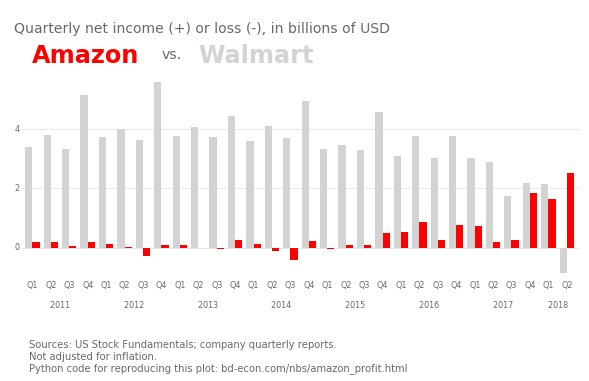

In [5]:
data = (df / 1_000_000_000).iloc[:, ::-1]

data.plot(kind='bar', width=0.78, color=['lightgray', 'red'], figsize=(10,5), zorder=2)
    
plt.ylim(ymax=8)
# add title and footer
plt.text(-1, 7.25, 'Quarterly net income (+) or loss (-), in billions of USD', fontsize=14, color='dimgray')
plt.text(7.0, 6.4, 'vs.', fontsize=14, color='dimgray')
plt.text(9, 6.25, 'Walmart', fontsize=24, color='lightgray', fontweight='bold')
plt.text(0, 6.25, 'Amazon', fontsize=24, color='red', fontweight='bold')

plt.text(-0.2, -4.2, 
         'Sources: US Stock Fundamentals; company quarterly reports. \n'
         'Not adjusted for inflation.\n'
         'Python code for reproducing this plot: bd-econ.com/nbs/amazon_profit.html', 
         color='dimgray')

for y in [0, 2, 4]:  # custom horizontal gridlines
    plt.axhline(y, color='lightgray', linewidth=0.5, zorder=1)
    plt.text(-0.7, y, str(y), fontsize=8, color='dimgray', va='center', ha='right')

xticks = []
for year in range(2011, 2018):
    xticks.extend(['Q1', f'Q2\n\n  {year}', 'Q3', 'Q4'])
xticks.extend(['Q1\n\n  2018', 'Q2'])
for i, tick in enumerate(xticks):
    plt.text(i-0.3, -1.1, tick, va='top', fontsize=8, color='dimgray')

plt.legend().remove()

plt.axis('off')
plt.savefig('AmazonWalmartNetIncomeLoss.png', bbox_inches='tight')
plt.show()